In [1]:
import os
import sys


def setup_project_root(start_path='.'):
    """Find the project root, set it as the current working directory, and add it to sys.path."""
    current_path = os.path.abspath(start_path)
    while True:
        if '.git' in os.listdir(current_path):
            project_root = current_path
            break
        parent_path = os.path.dirname(current_path)
        if parent_path == current_path:  # We've reached the root directory
            raise Exception("Could not find project root (.git directory not found)")
        current_path = parent_path
    
    # Change the current working directory to the project root
    os.chdir(project_root)
    print(f"Current working directory set to: {os.getcwd()}")

    # Add project root to sys.path if it's not already there
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"Added {project_root} to sys.path")

# sets the current working directory to the project root
setup_project_root()

# Don't cache imports
%load_ext autoreload
%autoreload 2


Current working directory set to: /vol/bitbucket/dm2223/info-theory-experiments


# In this notebook we train the feature network to learn a feature that cannot be deocded with to predict x0 instead of x1
This is becuase I believe this is closer to what we want, v0 has unique info about the next time step that is not contained in any x0^i

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from info_theory_experiments.custom_datasets import GameOfLifeDatasetNoLoop
from info_theory_experiments.models import GeneralSmileMIEstimator

class GameOfLifeEncoder(nn.Module):
    def __init__(self, latent_dim=1):
        super(GameOfLifeEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, 3, stride=1, padding=1),  # Output: 128x10x10
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  # Output: 256x10x10
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),  # Output: 512x10x10
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),  # Output: 1024x10x10
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024 * 10 * 10, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

    def forward(self, x):
        # Ensure input is 4D: [batch_size, channels, height, width]
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension
        return self.encoder(x)

class GameOfLifeDecoder(nn.Module):
    def __init__(self, latent_dim=1):
        super(GameOfLifeDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024 * 10 * 10),
            nn.ReLU(),
            nn.Unflatten(1, (1024, 10, 10)),
            nn.ConvTranspose2d(1024, 512, 3, stride=1, padding=1),  # Output: 512x10x10
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, stride=1, padding=1),  # Output: 256x10x10
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1),  # Output: 128x10x10
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, 3, stride=1, padding=1),  # Output: 1x10x10
        )

    def forward(self, x):
        return self.decoder(x).squeeze(1)  # Remove channel dimension

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = GameOfLifeDatasetNoLoop(
    prepare=True,
    normalize=True,
    num_simulations=1000,
    time_steps=100,
    grid_size=10,
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize the models, loss function, and optimizers
encoder = GameOfLifeEncoder(latent_dim=1).to(device)
decoder = GameOfLifeDecoder(latent_dim=1).to(device)
mse_loss = nn.MSELoss()
optimizer_encoder = optim.Adam(encoder.parameters(), lr=1e-4)
optimizer_decoder = optim.Adam(decoder.parameters(), lr=1e-3)

decoupled_estimator = GeneralSmileMIEstimator(
    x_dim=1,
    y_dim=1,
    critic_output_size=32,
    x_critics_hidden_sizes=[256, 256],
    y_critics_hidden_sizes=[256, 256],
    clip=5,
    include_bias=True,
).to(device)

decoupled_optimizer = optim.Adam(decoupled_estimator.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}/{num_epochs}')
    total_decoder_loss = 0
    total_encoder_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data0 = data[:, 0].to(device)
        data1 = data[:, 1].to(device)

        # Forward pass
        data0_pred = decoder(encoder(data0))

        # Decoder that predicts x0 loss (minimize MSE)
        decoder_loss = mse_loss(data0_pred, data0)

        # Update decoder
        if batch_idx % 1 == 0:
            optimizer_decoder.zero_grad()
            decoder_loss.backward()
            optimizer_decoder.step()

        # update decoupled estimator
        decoupled_optimizer.zero_grad()
        v0 = encoder(data0)
        v1 = encoder(data1)
        mi = decoupled_estimator(v0, v1)
        decoupled_loss = -mi # maximize MI
        decoupled_loss.backward()
        decoupled_optimizer.step()

        # Recompute the forward pass for encoder loss
        if batch_idx % 1 == 0:
            optimizer_encoder.zero_grad()
            data0_pred = decoder(encoder(data0))
            v0 = encoder(data0)
            v1 = encoder(data1)
            mi = decoupled_estimator(v0, v1)
            encoder_loss = - 0.05 * mi - mse_loss(data0_pred, data0)
            # Update encoder
            optimizer_encoder.zero_grad()
            encoder_loss.backward()
            optimizer_encoder.step()
        
        total_decoder_loss += decoder_loss.item()
        total_encoder_loss += encoder_loss.item()
    
    # Print epoch statistics
    avg_decoder_loss = total_decoder_loss / len(train_loader)
    avg_encoder_loss = total_encoder_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Decoder Loss: {avg_decoder_loss:.4f}, Encoder Loss: {avg_encoder_loss:.4f}, MI: {mi.item():.4f}')

Image 0: mean = -0.00, Std Dev = 0.9974842071533203
Starting epoch 1/5
Epoch [1/5], Decoder Loss: 29.6593, Encoder Loss: -14.6687, MI: 0.0070
Starting epoch 2/5
Epoch [2/5], Decoder Loss: 0.9056, Encoder Loss: -0.9052, MI: -0.0239
Starting epoch 3/5
Epoch [3/5], Decoder Loss: 0.8600, Encoder Loss: -0.8656, MI: 0.7015
Starting epoch 4/5
Epoch [4/5], Decoder Loss: 0.8646, Encoder Loss: -0.8705, MI: -0.1420
Starting epoch 5/5
Epoch [5/5], Decoder Loss: 0.8543, Encoder Loss: -0.8755, MI: 0.7696


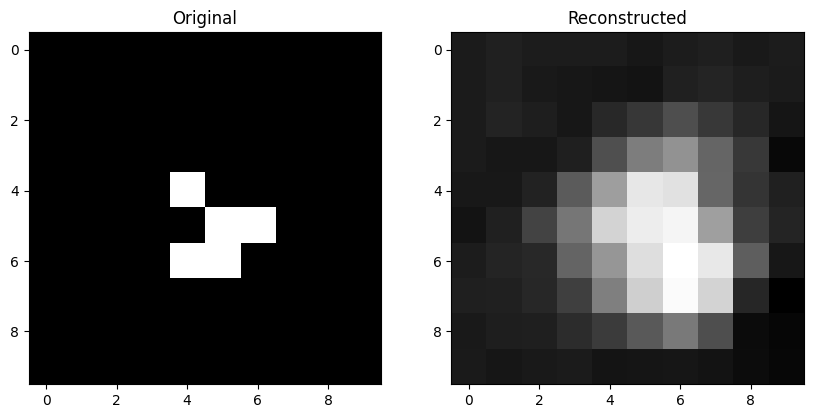

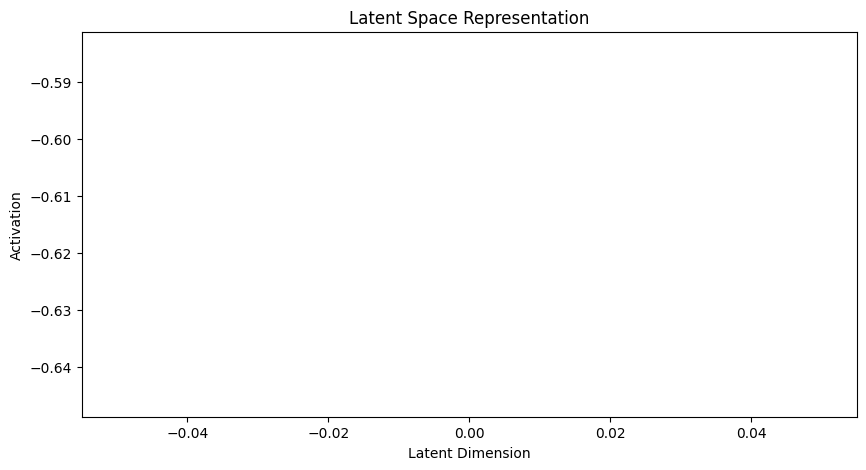

In [22]:
# Evaluate the model after training
encoder.eval()
decoder.eval()
with torch.no_grad():
    # Get a batch of test images
    test_loader = torch.utils.data.DataLoader(train_dataset[8:500], batch_size=1, shuffle=True)
    test_iter = iter(test_loader)
    images= next(test_iter)[:, 0]
    images = images.to(device).unsqueeze(1)

    # Reconstruct images
    reconstructed = decoder(encoder(images))

    # Visualize original and reconstructed images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(images.cpu().squeeze().numpy(), cmap='gray')
    ax1.set_title("Original")
    ax2.imshow(reconstructed.cpu().squeeze().numpy(), cmap='gray')
    ax2.set_title("Reconstructed")
    plt.show()

    # Visualize the latent space
    encoded_data = encoder(images).cpu().squeeze().numpy()
    plt.figure(figsize=(10, 5))
    plt.plot(encoded_data.flatten())
    plt.title(f"Latent Space Representation")
    plt.xlabel("Latent Dimension")
    plt.ylabel("Activation")
    plt.show()



In [23]:
from info_theory_experiments.trainers import train_feature_network
seed = 3
torch.manual_seed(seed)
config = {
    "torch_seed": seed,
    "dataset_type": "meg",
    "num_atoms": 116,
    "batch_size": 1000,
    "train_mode": False,
    "train_model_B": False,
    "adjust_Psi": True,
    "clip": 5,
    "feature_size": 1,
    "epochs": 2,
    "downward_critics_config": {
        "hidden_sizes_v_critic": [512, 1024, 1024, 512],
        "hidden_sizes_xi_critic": [512, 512, 512],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
    
    "decoupled_critic_config": {
        "hidden_sizes_encoder_1": [512, 512, 512],
        "hidden_sizes_encoder_2": [512, 512, 512],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
}

project_name = "gol-min-mse-_with_x0-max-mi-verification"

_, _ = train_feature_network(
    config=config,
    trainloader=train_loader,
    feature_network_training=encoder,
    project_name=project_name,
)